In [1]:
import pandas as pd
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
from natsort import natsorted

### Import data

In [2]:
def import_csv(file_name, model_name):
    df = pd.read_csv(file_name)
    df = df.add_prefix(model_name + '_')
    return df

file_names = ['RD Exam - Results - ChatGPT-4o.csv',
             'RD Exam - Results - Claude 3.5 - Sonnet.csv',
             'RD Exam - Results - Gemini-1.5-pro.csv']
model_names = ['GPT-4o', 'Claude-3.5', 'Gemini-1.5']
prompt_names = ['ZS', 'CoT', 'CoT-SC', 'RAP']

n = 0
for file_name, model_name in zip(file_names, model_names):
    if n == 0:
        df_input = import_csv(file_name, model_name)
        n += 1
    else:
        df_input = pd.concat([df_input, import_csv(file_name, model_name)], axis=1)


# Column names
question_column_name = 'GPT-4o_Question #'
true_column_name = 'GPT-4o_Ground Truth'
difficulty_column_name = 'GPT-4o_Difficulty'
category_column_name = 'GPT-4o_Category'
# Tags
gpt_tag = 'GPT-4o'
claude_tag = 'Claude-3.5'
gemini_tag = 'Gemini-1.5'
zs_tag = '_Zero'
cot_tag = '_CoT'
sc_tag = '_Self Consistency'
rag_tag = '_RAG'

### Extract CoT-SC

In [3]:
#CoT-SC

def add_sc(df, model_name, sc_tag = sc_tag):
    df = df.copy()
    list_of_sc = natsorted(df.filter(regex=model_name + '_SC CoT').columns.tolist())
    for i in range(5):
        df[model_name + sc_tag + ' (' + str(i+1) + ')'] = df[list_of_sc[i*3:(i+1)*3]].mode(axis=1)[0]
    return df

for model_name in model_names:
    df_input = add_sc(df=df_input, model_name=model_name)

### Data cleaning

In [4]:
zero_shot_column_names_gpt_4o = df_input.filter(regex=gpt_tag + zs_tag).columns.tolist()
cot_column_names_gpt_4o = df_input.filter(regex=gpt_tag + cot_tag).columns.tolist()
sc_column_names_gpt_4o = df_input.filter(regex=gpt_tag + sc_tag).columns.tolist()
rag_column_names_gpt_4o = df_input.filter(regex=gpt_tag + rag_tag).columns.tolist()
#
zero_shot_column_names_claude = df_input.filter(regex=claude_tag + zs_tag).columns.tolist()
cot_column_names_claude = df_input.filter(regex=claude_tag + cot_tag).columns.tolist()
sc_column_names_claude = df_input.filter(regex=claude_tag + sc_tag).columns.tolist()
rag_column_names_claude = df_input.filter(regex=claude_tag + rag_tag).columns.tolist()
#
zero_shot_column_names_gemini = df_input.filter(regex=gemini_tag + zs_tag).columns.tolist()
cot_column_names_gemini = df_input.filter(regex=gemini_tag + cot_tag).columns.tolist()
sc_column_names_gemini = df_input.filter(regex=gemini_tag + sc_tag).columns.tolist()
rag_column_names_gemini = df_input.filter(regex=gemini_tag + rag_tag).columns.tolist()
#
list_of_pred_column_names = [zero_shot_column_names_gpt_4o,
                             cot_column_names_gpt_4o,
                             sc_column_names_gpt_4o,
                             rag_column_names_gpt_4o,
                             zero_shot_column_names_claude,
                             cot_column_names_claude,
                             sc_column_names_claude,
                             rag_column_names_claude,
                             zero_shot_column_names_gemini,
                             cot_column_names_gemini,
                             sc_column_names_gemini,
                             rag_column_names_gemini,
                            ]
# The list of columns including all responses (3*4*5)
pred_column_names = []
for i in list_of_pred_column_names:
    pred_column_names.extend(i)
# The list of columns including one response per approach (3*4)
pred_column_names_one_per_approach = []
for i in list_of_pred_column_names:
    if i:
        pred_column_names_one_per_approach.append(i[0])

In [5]:
df_input_revised = df_input[pred_column_names]
# Missing data (NaN) handling
# Detect missing data
rows_with_nan = df_input_revised[df_input_revised.isna().any(axis=1)].index
nan_count = df_input_revised.isna().sum()
for column, count in nan_count.items():
    if count > 0:
        print(f"Column '{column}' has {count} NaNs")
#
# Replace NaN values with 'O'.
df_input_revised = df_input_revised.fillna("O")
rows_with_nan = df_input_revised[df_input_revised.isna().any(axis=1)].index

Column 'GPT-4o_CoT (5)' has 1 NaNs
Column 'GPT-4o_Self Consistency (1)' has 1 NaNs
Column 'Claude-3.5_RAG (1)' has 2 NaNs
Column 'Claude-3.5_RAG (2)' has 3 NaNs
Column 'Claude-3.5_RAG (3)' has 3 NaNs
Column 'Claude-3.5_RAG (4)' has 4 NaNs
Column 'Claude-3.5_RAG (5)' has 3 NaNs
Column 'Gemini-1.5_CoT (1)' has 16 NaNs
Column 'Gemini-1.5_CoT (2)' has 15 NaNs
Column 'Gemini-1.5_CoT (3)' has 25 NaNs
Column 'Gemini-1.5_CoT (4)' has 23 NaNs
Column 'Gemini-1.5_CoT (5)' has 21 NaNs
Column 'Gemini-1.5_Self Consistency (1)' has 6 NaNs
Column 'Gemini-1.5_Self Consistency (2)' has 6 NaNs
Column 'Gemini-1.5_Self Consistency (3)' has 6 NaNs
Column 'Gemini-1.5_Self Consistency (4)' has 6 NaNs
Column 'Gemini-1.5_Self Consistency (5)' has 6 NaNs
Column 'Gemini-1.5_RAG (1)' has 12 NaNs
Column 'Gemini-1.5_RAG (2)' has 13 NaNs
Column 'Gemini-1.5_RAG (3)' has 13 NaNs
Column 'Gemini-1.5_RAG (4)' has 13 NaNs
Column 'Gemini-1.5_RAG (5)' has 12 NaNs


In [6]:
true_answers = df_input[true_column_name].drop(rows_with_nan)
questions = df_input[question_column_name].drop(rows_with_nan)
difficulty_levels = df_input[difficulty_column_name].drop(rows_with_nan)
category_levels = df_input[category_column_name].drop(rows_with_nan)

### Compare with ground truth

In [7]:
# Compare the responses with the ground truth
def compare_with_ground_truth(df, col_pred, df_true):
    df = df.copy()
    for col in col_pred:
        # Compare each column with ground truth
        diff_col = (df[col] == df_true).astype(int)
        # Add new column to the DataFrame
        df.loc[:, f'Diff_{col}'] = diff_col
    return df
df_analysis = compare_with_ground_truth(df_input_revised, pred_column_names, true_answers)
#
# Create the Diff columns
diff_zero_shot_column_names_gpt_4o = df_analysis.filter(
    regex='^Diff_' + gpt_tag + zs_tag).columns.tolist()
diff_cot_column_names_gpt_4o = df_analysis.filter(
    regex='^Diff_' + gpt_tag + cot_tag).columns.tolist()
diff_sc_column_names_gpt_4o = df_analysis.filter(
    regex='^Diff_' + gpt_tag + sc_tag).columns.tolist()
diff_rag_column_names_gpt_4o = df_analysis.filter(
    regex='^Diff_' + gpt_tag + rag_tag).columns.tolist()
#
diff_zero_shot_column_names_claude = df_analysis.filter(
    regex='^Diff_' + claude_tag + zs_tag).columns.tolist()
diff_cot_column_names_claude = df_analysis.filter(
    regex='^Diff_' + claude_tag + cot_tag).columns.tolist()
diff_sc_column_names_claude = df_analysis.filter(
    regex='^Diff_' + claude_tag + sc_tag).columns.tolist()
diff_rag_column_names_claude = df_analysis.filter(
    regex='^Diff_' + claude_tag + rag_tag).columns.tolist()
#
diff_zero_shot_column_names_gemini = df_analysis.filter(
    regex='^Diff_' + gemini_tag + zs_tag).columns.tolist()
diff_cot_column_names_gemini = df_analysis.filter(
    regex='^Diff_' + gemini_tag + cot_tag).columns.tolist()
diff_sc_column_names_gemini = df_analysis.filter(
    regex='^Diff_' + gemini_tag + sc_tag).columns.tolist()
diff_rag_column_names_gemini = df_analysis.filter(
    regex='^Diff_' + gemini_tag + rag_tag).columns.tolist()
#
list_of_diff_columns_names = [diff_zero_shot_column_names_gpt_4o,
                              diff_cot_column_names_gpt_4o,
                              diff_sc_column_names_gpt_4o,
                              diff_rag_column_names_gpt_4o,
                              diff_zero_shot_column_names_claude,
                              diff_cot_column_names_claude,
                              diff_sc_column_names_claude,
                              diff_rag_column_names_claude,
                              diff_zero_shot_column_names_gemini,
                              diff_cot_column_names_gemini,
                              diff_sc_column_names_gemini,
                              diff_rag_column_names_gemini,
                             ]
# The list of columns including all differences (responses with ground truth) (3*4*5)
diff_column_names = []
for i in list_of_diff_columns_names:
    diff_column_names.extend(i)

### Accuracy - Overall Performance

In [8]:
# Count zeros and ones, percentage and error
counts_zero, counts_one = np.array([]), np.array([])
for col in diff_column_names:
    counts_zero = np.append(counts_zero, int((df_analysis[col] == 0).sum()))
for col in diff_column_names:
    counts_one = np.append(counts_one, int((df_analysis[col] == 1).sum()))
percentage = 100*(counts_one / (counts_one + counts_zero))

In [9]:
category_keywords_models = {
    'Diff_' + gpt_tag: model_names[0],
    'Diff_' + claude_tag: model_names[1],
    'Diff_' + gemini_tag: model_names[2],
}

category_keywords_prompts = {
    zs_tag: prompt_names[0],
    cot_tag: prompt_names[1],
    sc_tag: prompt_names[2],
    rag_tag: prompt_names[3],
}

def determine_category(label, keywords):
    for keyword, category in keywords.items():
        if keyword in label:
            return category
    return 'Unknown'

df_accuracy = pd.DataFrame({'percentage': percentage, 'errors': counts_zero,
                            'diff_column_names': diff_column_names,
                            'pred_column_names': pred_column_names})
df_accuracy['model'] = df_accuracy['diff_column_names'].apply(
    lambda x: determine_category(x, category_keywords_models))
df_accuracy['prompt'] = df_accuracy['diff_column_names'].apply(
    lambda x: determine_category(x, category_keywords_prompts))
df_accuracy['category'] = df_accuracy['model'] + ", " + df_accuracy['prompt']

rows = []
parameter = 'percentage'
for m in model_names:
    for p in prompt_names:
        values = df_accuracy.loc[df_accuracy['model'] == m].loc[
            df_accuracy['prompt'] == p][parameter].values
        rows.append({'category': m + ', ' + p,
                     'percentage_mean': np.mean(values),
                     'percentage_std': np.std(values)
                    })
df_accuracy_mean_std = pd.concat([pd.DataFrame(rows)], ignore_index=True)

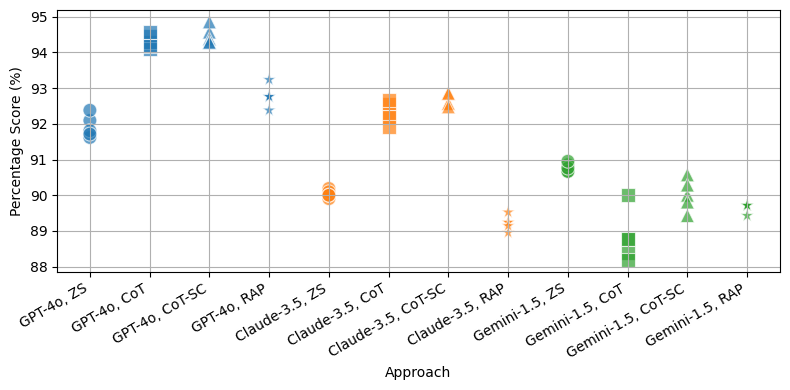

In [10]:
colors = sns.color_palette()[:4]
markers = ['o', 's', '^', '*']
custom_palette = {}
custom_markers = {}

for i, category in enumerate(df_accuracy['category'].unique()):
    color_index = i // 4  # Each color is used for three categories
    marker_index = i % 4  # Cycle through markers
    custom_palette[category] = colors[color_index]
    custom_markers[category] = markers[marker_index]

# Scatter plot
plt.figure(figsize=(8, 4))

sns.scatterplot(x='category', y='percentage', hue='category',
                data=df_accuracy, s=100, palette=custom_palette, 
                style='category', markers=custom_markers, edgecolor="w", alpha=0.7, legend=False)

plt.xlabel('Approach')
plt.ylabel('Percentage Score (%)')
plt.grid(True)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()

plt.savefig('accuracy_percentage.pdf')

plt.show()

In [11]:
df_accuracy_mean_std

,category,percentage_mean,percentage_std
0,"GPT-4o, ZS",91.923810,0.278643
1,"GPT-4o, CoT",94.323810,0.176640
2,"GPT-4o, CoT-SC",94.476190,0.217176
3,"GPT-4o, RAP",92.780952,0.272054
4,"Claude-3.5, ZS",90.038095,0.097124
5,"Claude-3.5, CoT",92.323810,0.273385
6,"Claude-3.5, CoT-SC",92.666667,0.159364
7,"Claude-3.5, RAP",89.219048,0.184674
8,"Gemini-1.5, ZS",90.780952,0.111066
9,"Gemini-1.5, CoT",88.819048,0.630588


### Accuracy - Proficiency level

In [12]:
def difficulty_to_number(array):
    mapping = {'Easy': 1, 'Moderate': 2, 'Difficult': 3, 'Expert': 4}
    vectorized_mapping = np.vectorize(mapping.get)
    return vectorized_mapping(array)

difficulty_levels_num = difficulty_to_number(difficulty_levels)
df_analysis['difficulty_level'] = difficulty_levels_num

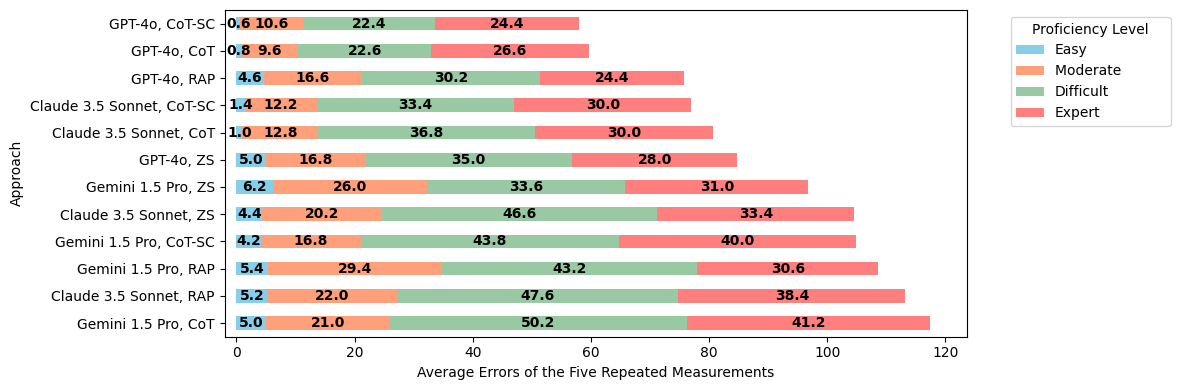

In [13]:
label_bars = ["GPT-4o, ZS", "GPT-4o, CoT", "GPT-4o, CoT-SC", "GPT-4o, RAP",
              "Claude 3.5 Sonnet, ZS", "Claude 3.5 Sonnet, CoT", "Claude 3.5 Sonnet, CoT-SC",
              "Claude 3.5 Sonnet, RAP",
              "Gemini 1.5 Pro, ZS", "Gemini 1.5 Pro, CoT", "Gemini 1.5 Pro, CoT-SC",
              "Gemini 1.5 Pro, RAP"]

search_list = ['Diff_GPT-4o_Zero', 'Diff_GPT-4o_CoT', 'Diff_GPT-4o_Self', 'Diff_GPT-4o_RAG',
               'Diff_Claude-3.5_Zero', 'Diff_Claude-3.5_CoT', 'Diff_Claude-3.5_Self',
               'Diff_Claude-3.5_RAG',
               'Diff_Gemini-1.5_Zero', 'Diff_Gemini-1.5_CoT', 'Diff_Gemini-1.5_Self',
               'Diff_Gemini-1.5_RAG']

df_error_level = pd.DataFrame()
for col in diff_column_names:
    errors_grouped = df_analysis[df_analysis[col] == 0].groupby(
        df_analysis['difficulty_level']).size() 
    df_error_level[col] = errors_grouped
df_error_level.fillna(0, inplace=True)

averages = {}
# Iterate through the search list
for term in search_list:
    # Identify columns that include the term
    matching_columns = [col for col in df_error_level.columns if term in col]
    if matching_columns:
        # Calculate the average of the matching columns
        averages[term] = df_error_level[matching_columns].mean(axis=1).values#.round(0).astype(int).values
# Convert the dictionary to a dataframe
df_error_level_average = pd.DataFrame([averages]).apply(pd.Series.explode)
df_error_level_average.columns = label_bars

# plot
fig, ax = plt.subplots(figsize=(12, 4))
total_error_average_counts = df_error_level_average.sum()
df_error_level_average_sorted = df_error_level_average.T.loc[
    total_error_average_counts.sort_values(ascending=False).index]
bars = df_error_level_average_sorted.plot(kind='barh', stacked=True, ax=ax,
                                          color = ['#87CEEB', '#FFA07A',
                                                   '#98c9a3', '#FF7F7F'])
# Customize the chart
ax.set_ylabel('Approach')
ax.set_xlabel('Average Errors of the Five Repeated Measurements')
ax.legend(title='Proficiency Level',
          labels=['Easy', 'Moderate          ', 'Difficult', 'Expert'],
          bbox_to_anchor=(1.05, 1), loc='upper left')

for bar in ax.patches:
    # Calculate the center of the bar
    bar_text = f'{round(bar.get_width(),1)}'
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_y() + bar.get_height() / 2,
        bar_text,
        ha='center',
        va='center',
        color='black',
        weight='bold'
    )
ax.set_xlim(-2, ax.set_xlim()[1] + 0.3)

plt.tight_layout()
plt.savefig('accuracy_error_subgroup_difficulty.pdf')
plt.show()

In [14]:
df_error_level_average

,"GPT-4o, ZS","GPT-4o, CoT","GPT-4o, CoT-SC","GPT-4o, RAP","Claude 3.5 Sonnet, ZS","Claude 3.5 Sonnet, CoT","Claude 3.5 Sonnet, CoT-SC","Claude 3.5 Sonnet, RAP","Gemini 1.5 Pro, ZS","Gemini 1.5 Pro, CoT","Gemini 1.5 Pro, CoT-SC","Gemini 1.5 Pro, RAP"
0,5.0,0.8,0.6,4.6,4.4,1.0,1.4,5.2,6.2,5.0,4.2,5.4
0,16.8,9.6,10.6,16.6,20.2,12.8,12.2,22.0,26.0,21.0,16.8,29.4
0,35.0,22.6,22.4,30.2,46.6,36.8,33.4,47.6,33.6,50.2,43.8,43.2
0,28.0,26.6,24.4,24.4,33.4,30.0,30.0,38.4,31.0,41.2,40.0,30.6


### Accuracy - Subdomains

In [15]:
def subcat_to_number(array):
    mapping = {'Principles of Dietetics': 1,
               'Nutrition Care for Individuals and Groups': 2,
               'Foodservice Systems': 3,
               'Management of Food and Nutrition Programs and Services': 4}
    vectorized_mapping = np.vectorize(mapping.get)
    return vectorized_mapping(array)

category_levels_num = subcat_to_number(category_levels)
df_analysis['category_level'] = category_levels_num

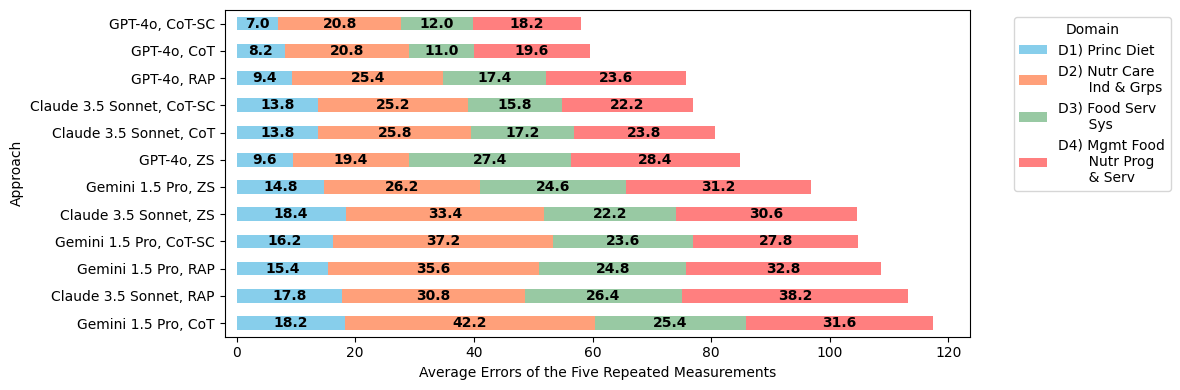

In [16]:
label_bars = ["GPT-4o, ZS", "GPT-4o, CoT", "GPT-4o, CoT-SC", "GPT-4o, RAP",
              "Claude 3.5 Sonnet, ZS", "Claude 3.5 Sonnet, CoT", "Claude 3.5 Sonnet, CoT-SC",
              "Claude 3.5 Sonnet, RAP",
              "Gemini 1.5 Pro, ZS", "Gemini 1.5 Pro, CoT", "Gemini 1.5 Pro, CoT-SC",
              "Gemini 1.5 Pro, RAP"]

search_list = ['Diff_GPT-4o_Zero', 'Diff_GPT-4o_CoT', 'Diff_GPT-4o_Self', 'Diff_GPT-4o_RAG',
               'Diff_Claude-3.5_Zero', 'Diff_Claude-3.5_CoT', 'Diff_Claude-3.5_Self',
               'Diff_Claude-3.5_RAG',
               'Diff_Gemini-1.5_Zero', 'Diff_Gemini-1.5_CoT', 'Diff_Gemini-1.5_Self',
               'Diff_Gemini-1.5_RAG']

df_subcat = pd.DataFrame()
for col in diff_column_names:
    errors_grouped = df_analysis[df_analysis[col] == 0].groupby(
        df_analysis['category_level']).size()
    
    df_subcat[col] = errors_grouped
df_subcat.fillna(0, inplace=True)

averages = {}
# Iterate through the search list
for term in search_list:
    # Identify columns that include the term
    matching_columns = [col for col in df_subcat.columns if term in col]
    if matching_columns:
        # Calculate the average of the matching columns
        averages[term] = df_subcat[matching_columns].mean(axis=1).values #.round(0).astype(int).values

# Convert the dictionary to a dataframe
df_subcat_average = pd.DataFrame([averages]).apply(pd.Series.explode)
df_subcat_average.columns = label_bars

# plot
fig, ax = plt.subplots(figsize=(12, 4))

total_error_average_counts = df_subcat_average.sum()
df_subcat_average_sorted = df_subcat_average.T.loc[
    total_error_average_counts.sort_values(ascending=False).index]

bars = df_subcat_average_sorted.plot(kind='barh', stacked=True, ax=ax,
                                          color = ['#87CEEB', '#FFA07A',
                                                   '#98c9a3', '#FF7F7F'])

# Customize the chart
ax.set_ylabel('Approach')
ax.set_xlabel('Average Errors of the Five Repeated Measurements')
legend = ax.legend(title='Domain',
          labels=['D1) Princ Diet',
                  'D2) Nutr Care\n       Ind & Grps',
                  'D3) Food Serv\n       Sys',
                  'D4) Mgmt Food\n       Nutr Prog\n       & Serv'],
          bbox_to_anchor=(1.05, 1), loc='upper left')

for bar in ax.patches:
    # Calculate the center of the bar
    bar_text = f'{round(bar.get_width(),1)}'
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_y() + bar.get_height() / 2,
        bar_text,
        ha='center',
        va='center',
        color='black',
        weight='bold'
    )
ax.set_xlim(-2, ax.set_xlim()[1] + 0.3)

plt.tight_layout()
plt.savefig('accuracy_error_subgroup_cagetory.pdf')
plt.show()

In [17]:
df_subcat_average

,"GPT-4o, ZS","GPT-4o, CoT","GPT-4o, CoT-SC","GPT-4o, RAP","Claude 3.5 Sonnet, ZS","Claude 3.5 Sonnet, CoT","Claude 3.5 Sonnet, CoT-SC","Claude 3.5 Sonnet, RAP","Gemini 1.5 Pro, ZS","Gemini 1.5 Pro, CoT","Gemini 1.5 Pro, CoT-SC","Gemini 1.5 Pro, RAP"
0,9.6,8.2,7.0,9.4,18.4,13.8,13.8,17.8,14.8,18.2,16.2,15.4
0,19.4,20.8,20.8,25.4,33.4,25.8,25.2,30.8,26.2,42.2,37.2,35.6
0,27.4,11.0,12.0,17.4,22.2,17.2,15.8,26.4,24.6,25.4,23.6,24.8
0,28.4,19.6,18.2,23.6,30.6,23.8,22.2,38.2,31.2,31.6,27.8,32.8


### Consistency - Paried Comparison

In [18]:
def choice_to_number(array):
    mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'O': 5}
    vectorized_mapping = np.vectorize(mapping.get)
    return vectorized_mapping(array)


# Find the paired combinations
comb_paired = [list(pair) for pair in combinations(pred_column_names_one_per_approach, 2)]
#
for paired in comb_paired:
    pair1 = choice_to_number(df_analysis[paired[0]].values)
    pair2 = choice_to_number(df_analysis[paired[1]].values)
    # Prepare R values
    numpy2ri.activate()
    r_input = np.column_stack((pair1, pair2))
    r_input = numpy2ri.py2rpy(r_input)
    robjects.globalenv['r_input'] = r_input

    r_code = """
    library(irr)
    library(boot)
    
    mydata <- (r_input)
    kappa_result_irr <- kappa2(mydata, weight = "unweighted")

    ckappa.fun <- function(data, indices)
    {
        # Create a bootstrap sample
        d <- data[indices, ]
        # Calculate Cohen's kappa
        kc <- kappa2(d, weight = "unweighted")
        return(kc$value)
    }
    boot_statistic <- boot(data=mydata, statistic=ckappa.fun, R = 2000)
    boot_ci_out <- boot.ci(boot.out = boot_statistic, type = c("norm", "basic", "perc", "bca"))
    """
    
    # Execute the R code
    robjects.r(r_code)
    
    # Retrieve the result
    kappa_result_irr = robjects.r['kappa_result_irr']
    bootstrap_stat = robjects.r['boot_statistic']
    bootstrap_ci = robjects.r['boot_ci_out']
    print(paired)
    print(kappa_result_irr)
    print(bootstrap_stat)
    print(bootstrap_ci)
    print('#####################')
    print()

R[write to console]: Loading required package: lpSolve



['GPT-4o_Zero-shot no explanation (1)', 'GPT-4o_CoT (1)']
 Cohen's Kappa for 2 Raters (Weights: unweighted)

 Subjects = 1050 
   Raters = 2 
    Kappa = 0.911 

        z = 51.1 
  p-value = 0 


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = mydata, statistic = ckappa.fun, R = 2000)


Bootstrap Statistics :
     original        bias    std. error
t1* 0.9110678 -0.0005654045  0.01003587

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = boot_statistic, type = c("norm", "basic", 
    "perc", "bca"))

Intervals : 
Level      Normal              Basic         
95%   ( 0.8920,  0.9313 )   ( 0.8923,  0.9315 )  

Level     Percentile            BCa          
95%   ( 0.8906,  0.9299 )   ( 0.8907,  0.9301 )  
Calculations and Intervals on Original Scale

#####################

['GPT-4o_Zero-shot no explanation (1)', 'GPT-4o_Self Consistency (1)']
 Cohen's Kappa for 2 Raters (Weights: unweighted)

 Subjects = 1050 
   Raters = 2 
  

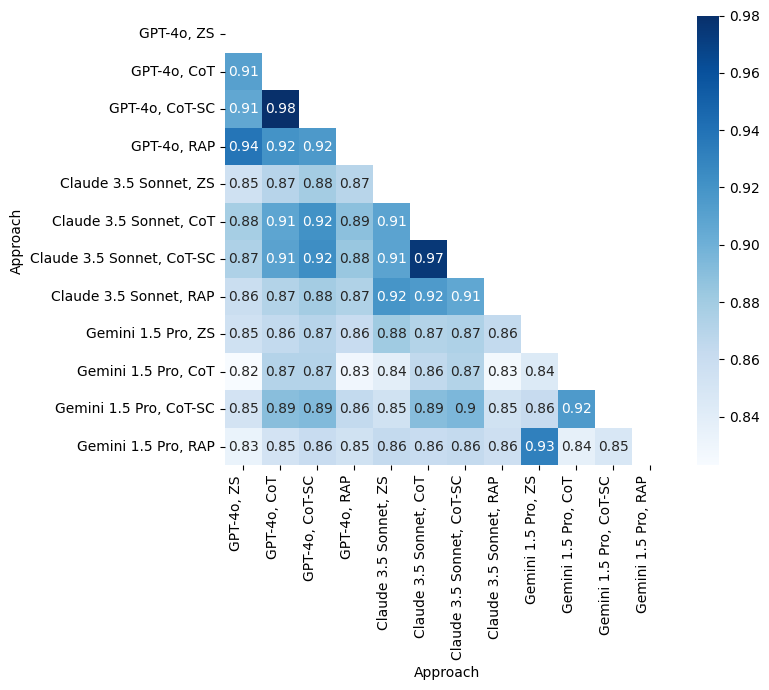

In [19]:
label_heatmap = ["GPT-4o, ZS", "GPT-4o, CoT",
                 "GPT-4o, CoT-SC", "GPT-4o, RAP",
                 "Claude 3.5 Sonnet, ZS", "Claude 3.5 Sonnet, CoT",
                 "Claude 3.5 Sonnet, CoT-SC", "Claude 3.5 Sonnet, RAP",
                 "Gemini 1.5 Pro, ZS", "Gemini 1.5 Pro, CoT",
                 "Gemini 1.5 Pro, CoT-SC", "Gemini 1.5 Pro, RAP"]

cohen_heatmap = np.array([
    [np.nan, 0.911, 0.906, 0.938, 0.855, 0.878, 0.874, 0.859, 0.855, 0.823, 0.852, 0.833],
    [ 0.911,np.nan, 0.980, 0.920, 0.870, 0.908, 0.910, 0.872, 0.864, 0.871, 0.890, 0.852],
    [ 0.906, 0.980,np.nan, 0.916, 0.879, 0.921, 0.923, 0.879, 0.870, 0.871, 0.893, 0.861],
    [ 0.938, 0.920, 0.916,np.nan, 0.869, 0.889, 0.884, 0.873, 0.861, 0.829, 0.864, 0.854],
    [ 0.855, 0.870, 0.879, 0.869,np.nan, 0.909, 0.909, 0.919, 0.881, 0.839, 0.854, 0.863],
    [ 0.878, 0.908, 0.921, 0.889, 0.909,np.nan, 0.975, 0.915, 0.872, 0.865, 0.891, 0.861],
    [ 0.874, 0.910, 0.923, 0.884, 0.909, 0.975,np.nan, 0.907, 0.874, 0.872, 0.895, 0.863],
    [ 0.859, 0.872, 0.879, 0.873, 0.919, 0.915, 0.907,np.nan, 0.864, 0.827, 0.854, 0.857],
    [ 0.855, 0.864, 0.870, 0.861, 0.881, 0.872, 0.874, 0.864,np.nan, 0.844, 0.862, 0.932],
    [ 0.823, 0.871, 0.871, 0.829, 0.839, 0.865, 0.872, 0.827, 0.844,np.nan, 0.915, 0.837],
    [ 0.852, 0.890, 0.893, 0.864, 0.854, 0.891, 0.895, 0.854, 0.862, 0.915,np.nan, 0.848],
    [ 0.833, 0.852, 0.861, 0.854, 0.863, 0.861, 0.863, 0.857, 0.932, 0.837, 0.848,np.nan]
])

mask = np.triu(np.ones_like(cohen_heatmap, dtype=bool))
plt.figure(figsize=(8, 7))
sns.heatmap(cohen_heatmap, annot=True, cbar=True, cmap="Blues",
            xticklabels=label_heatmap, yticklabels=label_heatmap, mask=mask) # 
plt.xlabel('Approach')
plt.ylabel('Approach')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.savefig('agreement_heatmap.pdf')

plt.show()

### Consistency - Overall Agreement

In [20]:
def fleiss_kappa(df, col_names):
    # Prepare R values
    numpy2ri.activate()
    cat_num = choice_to_number(df[col_names].values)
    # Convert the NumPy array to an R object
    r_input = numpy2ri.py2rpy(cat_num)
    # Assign the R object to a variable in R's global environment
    robjects.globalenv['r_input'] = r_input

    r_code = """
    
    library("irr")
    library(boot)
    
    mydata <- (r_input)
    kappa_result <- kappam.fleiss(mydata)
    
    fkappa.fun <- function(data, indices)
    {
        # Create a bootstrap sample
        d <- data[indices, ]
        # Calculate Fleiss' kappa
        kf <- kappam.fleiss(d)
        return(kf$value)
    }
    boot_statistic <- boot(data=mydata, statistic=fkappa.fun, R = 2000)
    boot_ci_out <- boot.ci(boot.out = boot_statistic, type = c("norm", "basic", "perc", "bca"))
    
    """

    # Execute the R code
    robjects.r(r_code)
    
    # Retrieve the result
    kappa_result = robjects.r['kappa_result']
    bootstrap_stat = robjects.r['boot_statistic']
    bootstrap_ci = robjects.r['boot_ci_out']
    print(kappa_result)
    print(bootstrap_stat)
    print(bootstrap_ci)
    print('#####################')
    print()

#GPT ZS
print('GPT-4o, ZS')
fleiss_kappa(df_analysis, zero_shot_column_names_gpt_4o)

#GPT CoT
print('GPT-4o, CoT')
fleiss_kappa(df_analysis, cot_column_names_gpt_4o)

#GPT SC
print('GPT-4o, SC')
fleiss_kappa(df_analysis, sc_column_names_gpt_4o)

#GPT RAP
print('GPT-4o, RAP')
fleiss_kappa(df_analysis, rag_column_names_gpt_4o)

# Claude ZS
print('Claude, ZS')
fleiss_kappa(df_analysis, zero_shot_column_names_claude)

# Claude CoT
print('Claude, CoT')
fleiss_kappa(df_analysis, cot_column_names_claude)

# Claude SC
print('Claude, SC')
fleiss_kappa(df_analysis, sc_column_names_claude)

# Claude RAP
print('Claude, RAP')
fleiss_kappa(df_analysis, rag_column_names_claude)

# Gemini ZS
print('Gemini, ZS')
fleiss_kappa(df_analysis, zero_shot_column_names_gemini)

# Gemini CoT
print('Gemini, CoT')
fleiss_kappa(df_analysis, cot_column_names_gemini)

# Gemini SC
print('Gemini, SC')
fleiss_kappa(df_analysis, sc_column_names_gemini)

# Gemini RAG
print('Gemini, RAG')
fleiss_kappa(df_analysis, rag_column_names_gemini)

GPT-4o, ZS
 Fleiss' Kappa for m Raters

 Subjects = 1050 
   Raters = 5 
    Kappa = 0.98 

        z = 174 
  p-value = 0 


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = mydata, statistic = fkappa.fun, R = 2000)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.9800541 0.0001924858 0.003584176

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = boot_statistic, type = c("norm", "basic", 
    "perc", "bca"))

Intervals : 
Level      Normal              Basic         
95%   ( 0.9728,  0.9869 )   ( 0.9732,  0.9876 )  

Level     Percentile            BCa          
95%   ( 0.9725,  0.9869 )   ( 0.9713,  0.9858 )  
Calculations and Intervals on Original Scale

#####################

GPT-4o, CoT
 Fleiss' Kappa for m Raters

 Subjects = 1050 
   Raters = 5 
    Kappa = 0.969 

        z = 172 
  p-value = 0 


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = mydata, statistic = fkappa.fun, R = 2000)


Boots